# DenseNet RGB

## 1. Mount Google Drive (Colab Only)
This section connects to Google Drive to access the dataset.

In [1]:
!pip install lightning polars
!pip install tqdm
!pip install --upgrade torchvision
!pip install numpy
!pip install matplotlib
!pip install pandas
!pip install seaborn
!pip install opencv-python
!pip install scikit-learn

## 2. Import Libraries
Imports all required packages including PyTorch, Lightning, and data processing tools.

In [2]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import polars as pl
import numpy as np
import lightning as L
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from datetime import datetime
from torchvision import transforms
from torchvision.transforms import v2
from torchvision import transforms as v2
import pandas as pd
from tqdm import tqdm
from PIL import Image


# Model imports
import torchvision
import torchvision.models as models

# Metrics imports
from torchmetrics import (
    Accuracy,
    F1Score,
    AUROC,
    ConfusionMatrix,
    Precision,
    Recall
)
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18
from torchvision import transforms, tv_tensors
import os
import random
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
print("GPU available:", torch.cuda.is_available())

GPU available: True


## Training + Evaluation of methods

In [4]:
classes = [
    'Paper & Cardboard', 'Metal', 'Plastic','Organic Waste','Textiles',
    'Glass', 'Hazardous Waste', 'Trash'
]

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### Method 5 Training

In [5]:

# Custom Dataset class for the folder structure
class GarbageDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None, classes=None, is_train=False):
        self.data_frame = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.classes = classes  # Add classes attribute
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)} # Create a dictionary to map class names to indices
        self.is_train = is_train
        # Enhanced augmentation for training
        self.train_transforms = v2.Compose([
            v2.RandomHorizontalFlip(p=0.5),
            v2.RandomVerticalFlip(p=0.5),
            v2.RandomRotation(degrees=15),
            v2.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            v2.RandomErasing(p=0.2),
        ])
    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        # Get image filename and label from CSV
        img_name = self.data_frame.iloc[idx, 0]  # Assuming first column contains the filename
        label = self.data_frame.iloc[idx, 1]     # Assuming second column contains the label
        # Build full image path - images are directly in the main folder
        img_path = img_name

        # Load and convert to RGB for DenseNet
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        if self.is_train:
            image = self.train_transforms(image)

        # Convert string label to numerical index
        label_idx = self.class_to_idx[label] # Get the numerical index corresponding to the string label
        label_idx = torch.tensor(label_idx)  # Convert the index to a PyTorch tensor

        return image, label_idx



In [6]:
# Define paths
base_dir = ""
img_dir = f"{base_dir}RGB_preprocessed_images/RGB_preprocessed_images"
train_csv = f"{img_dir}/train.csv"
val_csv = f"{img_dir}/validation.csv"
test_csv = f"{img_dir}/test.csv"

# Create datasets and dataloaders
batch_size = 16

# Add initial data checking
print("Loading datasets...")
try:
    train_dataset = GarbageDataset(train_csv, img_dir, transform=transform, classes=classes, is_train=True)
    val_dataset = GarbageDataset(val_csv, img_dir, transform=transform, classes=classes, is_train=False)
    test_dataset = GarbageDataset(test_csv, img_dir, transform=transform, classes=classes, is_train=False)


    # Print a sample image filename to verify path construction
    sample_idx = 0
    img_name = train_dataset.data_frame.iloc[sample_idx, 0]
    img_path = img_name
    print(f"Sample image path: {img_path}")

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True,persistent_workers=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True,persistent_workers=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True,persistent_workers=True)

    print(f"Train dataset size: {len(train_dataset)}")
    print(f"Validation dataset size: {len(val_dataset)}")
    print(f"Test dataset size: {len(test_dataset)}")
except Exception as e:
    print(f"Error loading datasets: {e}")
    raise


Loading datasets...
Sample image path: RGB_preprocessed_images/RGB_preprocessed_images/train/Glass_0_processed.jpeg
Train dataset size: 12670
Validation dataset size: 1091
Test dataset size: 1090


In [7]:
# Load pre-trained DenseNet model using torch.hub
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
# Replace the final layer (for example, to fit your number of classes)
num_ftrs = model.classifier.in_features
# Modify the classifier for our 7 classes
model.classifier = nn.Sequential(
    nn.Dropout(p=0.3),
    nn.Linear(num_ftrs,len(classes)) )

In [8]:
# Training function
def train_epoch(model, train_loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        #gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / total
    train_acc = correct / total
    return train_loss, train_acc

# Validation function
def validate(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = running_loss / total
    val_acc = correct / total
    return val_loss, val_acc


# Main training loop
def train_model(trainversion, model, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs=15):
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    best_val_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        # Train
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)

        # Validate
        val_loss, val_acc = validate(model, val_loader, criterion)

        # Update scheduler
        scheduler.step(val_loss)

        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(),f"best_densenet_model_{trainversion}.pth")
            print(f"New best model saved with accuracy: {val_acc:.4f}")

    # Load best model
    model.load_state_dict(torch.load(f"best_densenet_model_{trainversion}.pth"))
    return model, history

# Function to evaluate on test set
def evaluate(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)

    # Generate confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Print classification report
    print(classification_report(all_labels, all_preds, target_names=classes))

    return accuracy, conf_matrix


# Plot training history
def plot_history(history, trainversion):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"training_history_{trainversion}.png")
    plt.show()

# Plot confusion matrix
def plot_confusion_matrix(conf_matrix, class_names, trainversion):
    plt.figure(figsize=(10, 8))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=90)
    plt.yticks(tick_marks, class_names)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(f"confusion_matrix_{trainversion}.png")
    plt.show()

Starting model training...
Epoch 1/30


Validation: 100%|██████████| 69/69 [00:01<00:00, 38.45it/s]


Train Loss: 0.8770, Train Acc: 0.8355
Val Loss: 0.6827, Val Acc: 0.9313
New best model saved with accuracy: 0.9313
Epoch 2/30


Validation: 100%|██████████| 69/69 [00:01<00:00, 45.13it/s]


Train Loss: 0.6712, Train Acc: 0.9291
Val Loss: 0.6498, Val Acc: 0.9377
New best model saved with accuracy: 0.9377
Epoch 3/30


Validation: 100%|██████████| 69/69 [00:01<00:00, 46.36it/s]


Train Loss: 0.6202, Train Acc: 0.9513
Val Loss: 0.6252, Val Acc: 0.9468
New best model saved with accuracy: 0.9468
Epoch 4/30


Validation: 100%|██████████| 69/69 [00:01<00:00, 41.63it/s]


Train Loss: 0.5900, Train Acc: 0.9629
Val Loss: 0.6247, Val Acc: 0.9441
Epoch 5/30


Validation: 100%|██████████| 69/69 [00:01<00:00, 42.64it/s]


Train Loss: 0.5665, Train Acc: 0.9725
Val Loss: 0.6029, Val Acc: 0.9478
New best model saved with accuracy: 0.9478
Epoch 6/30


Validation: 100%|██████████| 69/69 [00:01<00:00, 46.13it/s]


Train Loss: 0.5535, Train Acc: 0.9753
Val Loss: 0.6120, Val Acc: 0.9468
Epoch 7/30


Validation: 100%|██████████| 69/69 [00:01<00:00, 45.39it/s]


Train Loss: 0.5451, Train Acc: 0.9764
Val Loss: 0.6225, Val Acc: 0.9423
Epoch 8/30


Validation: 100%|██████████| 69/69 [00:01<00:00, 45.62it/s]


Train Loss: 0.5373, Train Acc: 0.9783
Val Loss: 0.6014, Val Acc: 0.9542
New best model saved with accuracy: 0.9542
Epoch 9/30


Validation: 100%|██████████| 69/69 [00:01<00:00, 46.43it/s]


Train Loss: 0.5313, Train Acc: 0.9809
Val Loss: 0.6179, Val Acc: 0.9441
Epoch 10/30


Validation: 100%|██████████| 69/69 [00:01<00:00, 42.38it/s]


Train Loss: 0.5268, Train Acc: 0.9811
Val Loss: 0.6287, Val Acc: 0.9386
Epoch 11/30


Validation: 100%|██████████| 69/69 [00:01<00:00, 43.21it/s]


Train Loss: 0.5259, Train Acc: 0.9815
Val Loss: 0.6398, Val Acc: 0.9404
Epoch 12/30


Validation: 100%|██████████| 69/69 [00:01<00:00, 44.75it/s]


Train Loss: 0.5033, Train Acc: 0.9899
Val Loss: 0.6300, Val Acc: 0.9441
Epoch 13/30


Validation: 100%|██████████| 69/69 [00:01<00:00, 44.50it/s]


Train Loss: 0.4979, Train Acc: 0.9916
Val Loss: 0.6192, Val Acc: 0.9505
Epoch 14/30


Validation: 100%|██████████| 69/69 [00:01<00:00, 44.60it/s]


Train Loss: 0.4984, Train Acc: 0.9916
Val Loss: 0.6477, Val Acc: 0.9368
Epoch 15/30


Validation: 100%|██████████| 69/69 [00:01<00:00, 46.69it/s]


Train Loss: 0.4908, Train Acc: 0.9943
Val Loss: 0.6209, Val Acc: 0.9487
Epoch 16/30


Validation: 100%|██████████| 69/69 [00:01<00:00, 44.93it/s]


Train Loss: 0.4862, Train Acc: 0.9955
Val Loss: 0.6287, Val Acc: 0.9459
Epoch 17/30


Validation: 100%|██████████| 69/69 [00:01<00:00, 44.23it/s]


Train Loss: 0.4880, Train Acc: 0.9949
Val Loss: 0.6318, Val Acc: 0.9487
Epoch 18/30


Validation: 100%|██████████| 69/69 [00:01<00:00, 46.43it/s]


Train Loss: 0.4846, Train Acc: 0.9961
Val Loss: 0.6191, Val Acc: 0.9496
Epoch 19/30


Validation: 100%|██████████| 69/69 [00:01<00:00, 46.40it/s]


Train Loss: 0.4855, Train Acc: 0.9959
Val Loss: 0.6258, Val Acc: 0.9523
Epoch 20/30


Validation: 100%|██████████| 69/69 [00:01<00:00, 46.77it/s]


Train Loss: 0.4834, Train Acc: 0.9968
Val Loss: 0.6312, Val Acc: 0.9478
Epoch 21/30


Validation: 100%|██████████| 69/69 [00:01<00:00, 46.94it/s]


Train Loss: 0.4816, Train Acc: 0.9976
Val Loss: 0.6193, Val Acc: 0.9505
Epoch 22/30


Validation: 100%|██████████| 69/69 [00:01<00:00, 44.68it/s]


Train Loss: 0.4837, Train Acc: 0.9965
Val Loss: 0.6259, Val Acc: 0.9496
Epoch 23/30


Validation: 100%|██████████| 69/69 [00:01<00:00, 43.37it/s]


Train Loss: 0.4830, Train Acc: 0.9965
Val Loss: 0.6181, Val Acc: 0.9542
Epoch 24/30


Validation: 100%|██████████| 69/69 [00:01<00:00, 46.62it/s]


Train Loss: 0.4801, Train Acc: 0.9976
Val Loss: 0.6212, Val Acc: 0.9533
Epoch 25/30


Validation: 100%|██████████| 69/69 [00:01<00:00, 44.43it/s]


Train Loss: 0.4806, Train Acc: 0.9976
Val Loss: 0.6325, Val Acc: 0.9487
Epoch 26/30


Validation: 100%|██████████| 69/69 [00:01<00:00, 45.80it/s]


Train Loss: 0.4812, Train Acc: 0.9974
Val Loss: 0.6271, Val Acc: 0.9523
Epoch 27/30


Validation: 100%|██████████| 69/69 [00:01<00:00, 35.56it/s]


Train Loss: 0.4802, Train Acc: 0.9979
Val Loss: 0.6262, Val Acc: 0.9514
Epoch 28/30


Validation: 100%|██████████| 69/69 [00:01<00:00, 46.12it/s]


Train Loss: 0.4820, Train Acc: 0.9969
Val Loss: 0.6239, Val Acc: 0.9533
Epoch 29/30


Validation: 100%|██████████| 69/69 [00:01<00:00, 41.83it/s]


Train Loss: 0.4814, Train Acc: 0.9975
Val Loss: 0.6188, Val Acc: 0.9523
Epoch 30/30


Validation: 100%|██████████| 69/69 [00:01<00:00, 46.09it/s]


Train Loss: 0.4793, Train Acc: 0.9982
Val Loss: 0.6203, Val Acc: 0.9514


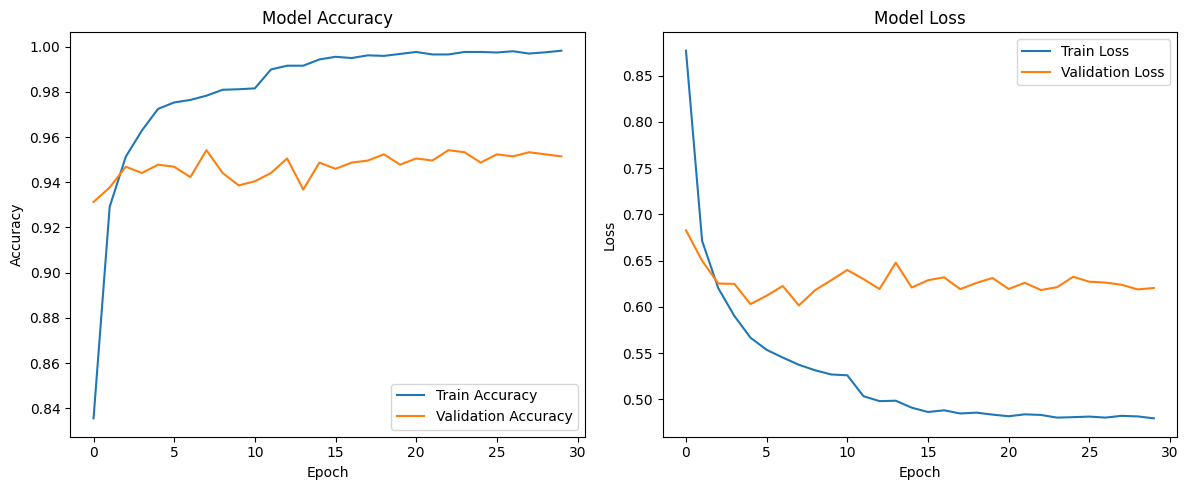

Evaluating model on test set...


Testing: 100%|██████████| 69/69 [00:01<00:00, 36.86it/s]


                   precision    recall  f1-score   support

Paper & Cardboard       0.98      0.94      0.96       150
            Metal       0.93      0.90      0.92       115
          Plastic       0.90      0.93      0.92       130
    Organic Waste       0.99      0.96      0.97       148
         Textiles       0.97      0.97      0.97       150
            Glass       0.93      0.95      0.94       150
  Hazardous Waste       0.93      1.00      0.97       142
            Trash       0.97      0.93      0.95       105

         accuracy                           0.95      1090
        macro avg       0.95      0.95      0.95      1090
     weighted avg       0.95      0.95      0.95      1090

Test Accuracy: 0.9505


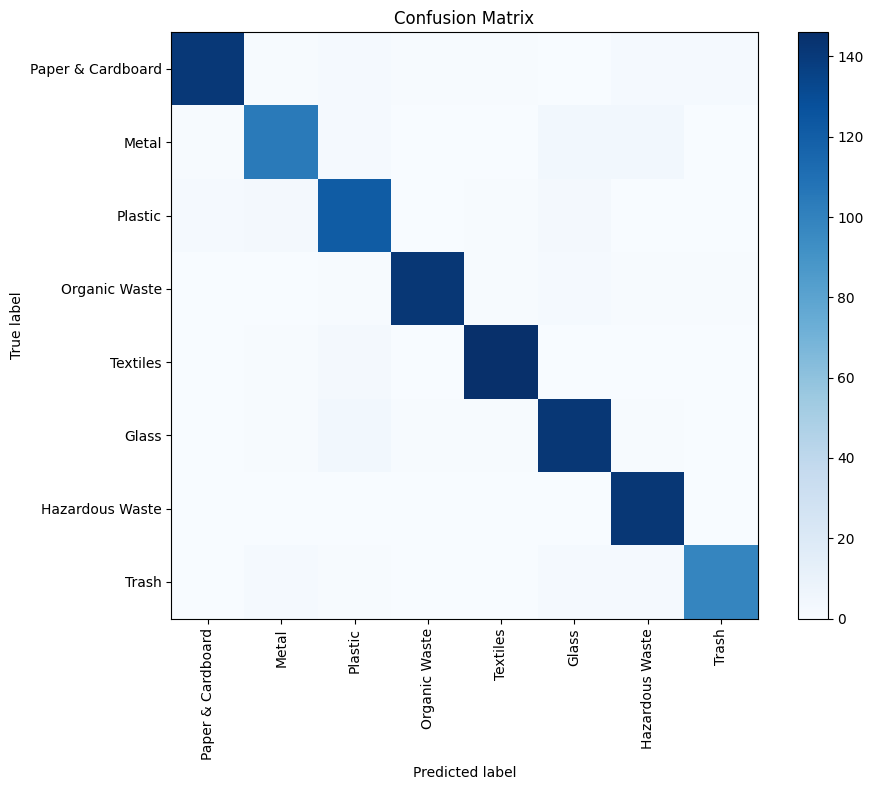

Training completed and model saved!


In [9]:
# Move model to device
model = model.to(device)
# Main execution - train and evaluate
num_epochs = 30
trainversion=7
print("Starting model training...")

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

model, history = train_model(trainversion, model, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs)

# Plot training history
plot_history(history, trainversion)

# Evaluate on test set
print("Evaluating model on test set...")
test_acc, conf_matrix = evaluate(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}")

# Plot confusion matrix
plot_confusion_matrix(conf_matrix, classes, trainversion)

# Save final model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'classes': classes
}, f"densenet121_RGB_test_acc={test_acc}.pth")

print("Training completed and model saved!")